In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
suburbs = []
subs = open('areas.txt', 'r')
for line in subs:
    line = line.replace('(', '')
    line = line.replace(')', '')
    line = line.strip()
    suburbs.append(line)
subs.close
print(suburbs)

['Aadhar Multispeciality Hospital, Narhe Pune', 'Anmol Multispeciality Clinic Hospital', 'ANUJA HOSPITAL', 'Bharati Hospital', 'City Care Hospital', 'City Hospital', 'Gawali Hospital', 'jalore hospital', 'Jeevan Uday Multispeciality Hospital', 'Khetmalas Hospital', 'KHETMALAS Hospital1', 'Lifeline Hospital', 'Mai Mangeshkar Hospital', 'Manas Hospital', 'MINERVA HOSPITAL', 'Mixis Multi Specialty Hospital', 'Nagare Nursing Home', 'Nanded Multispeciality Hospital', 'PATIL MULTISPECIALITY HOSPITAL AND LAPROSCOPY CENTER', 'Pune Medical and Research', 'Royal Hospital', 'Sai Sneh Hospital and Diagnostic Center', 'sanjivani hospital', 'Sharayu Multispeciality Hospital', 'SHIVNERI HOSPITAL', 'Shraddha Hospitals', 'SHREE HOSPITAL, NARHE, PUNE', 'Shreeyash Multi-speciality Hospital', 'Shrimangal hospital', 'Shwas Multispeciality Hospital', 'Siddhivinayak General Hospital', 'SILVER BIRCH MULTISPECIALITY HOSPITAL PVT.LTD', 'Sinhagad Speciality Hospital', 'Thube Nursing Home', 'VIGHNAHARTA HOSPITAL'

In [7]:
filenames = []
for i in range(0, len(suburbs)):
  filenames.append("./Reviews/"+str(suburbs[i])+"/reviews.csv")
  # filenames = [
  #             "./Reviews/ANUJA HOSPITAL/reviews.csv",
  #           ]

# merging two csv files
df = pd.concat(
    map(pd.read_csv, filenames), ignore_index=True)

print(len(df))
df

3654


,Rating,Review
0,5 stars,Best Multispecialty hospital in narhe near sin...
1,1 star,Not good hospital. Very very very much waiting...
2,1 star,Our patient got discharge 2 days before i expi...
3,5 stars,As a Surgeon I will always recommend Aadhar Mu...
4,5 stars,I am very frequent visitor to this hospital f...
...,...,...
3649,5 stars,None
3650,5 stars,None
3651,5 stars,None
3652,5 stars,None


In [8]:
review_remove_translated = []

reviews_dict = df.to_dict('list')

for review in reviews_dict['Review']:
  review_sep = str(review).split("(Translated by Google) ")
  
  # Jika terdapat (Translated by Google)
  if review_sep[0] == "":
    review_sep = ("".join(review_sep)).split("(Original)")
    review_sep = review_sep[0]
    review = "".join(review_sep)
  
  review_remove_translated.append(review)

In [9]:
reviews_dict['Review'] = review_remove_translated
df = pd.DataFrame(reviews_dict)
df

,Rating,Review
0,5 stars,Best Multispecialty hospital in narhe near sin...
1,1 star,Not good hospital. Very very very much waiting...
2,1 star,Our patient got discharge 2 days before i expi...
3,5 stars,As a Surgeon I will always recommend Aadhar Mu...
4,5 stars,I am very frequent visitor to this hospital f...
...,...,...
3649,5 stars,None
3650,5 stars,None
3651,5 stars,None
3652,5 stars,None


In [10]:
import string
import re

In [11]:
def clean_review(review):
    return re.sub('[^a-zA-Z]', ' ', review).lower()
  
df['cleaned_review'] = df['Review'].apply(lambda x: clean_review(str(x)))
df['label'] = df['Rating'].map({"1 star":0, "2 stars":0, "3 stars":0, "4 stars":1, "5 stars":1})

In [12]:
def count_punct(review):
    count = sum([1 for char in review if char in string.punctuation])
    return round(count/(len(review) - review.count(" ")), 3)*100
  
df['review_len'] = df['Review'].apply(lambda x: len(str(x)) - str(x).count(" "))
df['punct'] = df['Review'].apply(lambda x: count_punct(str(x)))
df

,Rating,Review,cleaned_review,label,review_len,punct
0,5 stars,Best Multispecialty hospital in narhe near sin...,best multispecialty hospital in narhe near sin...,1,332,2.4
1,1 star,Not good hospital. Very very very much waiting...,not good hospital very very very much waiting...,0,224,3.6
2,1 star,Our patient got discharge 2 days before i expi...,our patient got discharge days before i expi...,0,394,2.8
3,5 stars,As a Surgeon I will always recommend Aadhar Mu...,as a surgeon i will always recommend aadhar mu...,1,319,5.3
4,5 stars,I am very frequent visitor to this hospital f...,i am very frequent visitor to this hospital f...,1,167,4.8
...,...,...,...,...,...,...
3649,5 stars,None,none,1,4,0.0
3650,5 stars,None,none,1,4,0.0
3651,5 stars,None,none,1,4,0.0
3652,5 stars,None,none,1,4,0.0


In [13]:
def tokenize_review(review):
    tokenized_review = review.split()
    return tokenized_review
  
df['tokens'] = df['cleaned_review'].apply(lambda x: tokenize_review(x))
df.head()

,Rating,Review,cleaned_review,label,review_len,punct,tokens
0,5 stars,Best Multispecialty hospital in narhe near sin...,best multispecialty hospital in narhe near sin...,1,332,2.4,"[best, multispecialty, hospital, in, narhe, ne..."
1,1 star,Not good hospital. Very very very much waiting...,not good hospital very very very much waiting...,0,224,3.6,"[not, good, hospital, very, very, very, much, ..."
2,1 star,Our patient got discharge 2 days before i expi...,our patient got discharge days before i expi...,0,394,2.8,"[our, patient, got, discharge, days, before, i..."
3,5 stars,As a Surgeon I will always recommend Aadhar Mu...,as a surgeon i will always recommend aadhar mu...,1,319,5.3,"[as, a, surgeon, i, will, always, recommend, a..."
4,5 stars,I am very frequent visitor to this hospital f...,i am very frequent visitor to this hospital f...,1,167,4.8,"[i, am, very, frequent, visitor, to, this, hos..."


In [14]:
import nltk
from nltk.corpus import stopwords
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

In [15]:
def lemmatize_review(token_list):
    return " ".join([lemmatizer.lemmatize(token) for token in token_list if not token in set(all_stopwords)])

lemmatizer = nltk.stem.WordNetLemmatizer()
df['lemmatized_review'] = df['tokens'].apply(lambda x: lemmatize_review(x))
df.head()

,Rating,Review,cleaned_review,label,review_len,punct,tokens,lemmatized_review
0,5 stars,Best Multispecialty hospital in narhe near sin...,best multispecialty hospital in narhe near sin...,1,332,2.4,"[best, multispecialty, hospital, in, narhe, ne...",best multispecialty hospital narhe near sinhga...
1,1 star,Not good hospital. Very very very much waiting...,not good hospital very very very much waiting...,0,224,3.6,"[not, good, hospital, very, very, very, much, ...",not good hospital much waiting report collecti...
2,1 star,Our patient got discharge 2 days before i expi...,our patient got discharge days before i expi...,0,394,2.8,"[our, patient, got, discharge, days, before, i...",patient got discharge day expirienced followin...
3,5 stars,As a Surgeon I will always recommend Aadhar Mu...,as a surgeon i will always recommend aadhar mu...,1,319,5.3,"[as, a, surgeon, i, will, always, recommend, a...",surgeon always recommend aadhar multispecialty...
4,5 stars,I am very frequent visitor to this hospital f...,i am very frequent visitor to this hospital f...,1,167,4.8,"[i, am, very, frequent, visitor, to, this, hos...",frequent visitor hospital wife treatment docto...


In [16]:
#  Shape of the dataset, and breakdown of the classes
print(f"Input data has { len(df) } rows and { len(df.columns) } columns")

Input data has 3654 rows and 8 columns


Number of null in label: 0
Number of null in text: 0


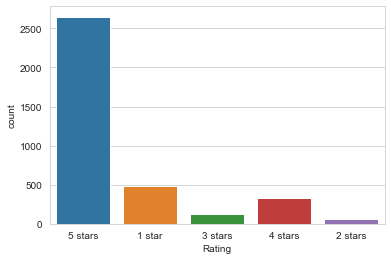

In [17]:
print(f"Number of null in label: { df['Rating'].isnull().sum() }")
print(f"Number of null in text: { df['Review'].isnull().sum() }")
sns.countplot(x='Rating', data=df);

In [18]:
X = df[['lemmatized_review', 'review_len', 'punct']]
y = df['label']
print(X.shape)
print(y.shape)

(3654, 3)
(3654,)


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2557, 3)
(1097, 3)
(2557,)
(1097,)


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df = 0.5, min_df = 2) # ignore terms that occur in more than 50% documents and the ones that occur in less than 2
tfidf_train = tfidf.fit_transform(X_train['lemmatized_review'])
tfidf_test = tfidf.transform(X_test['lemmatized_review'])

X_train_vect = pd.concat([X_train[['review_len', 'punct']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['review_len', 'punct']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,review_len,punct,0,1,2,3,4,5,6,7,...,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798
0,153,2.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47,2.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,283,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,53,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

              precision    recall  f1-score   support

           0       0.88      0.43      0.57       207
           1       0.88      0.99      0.93       890

    accuracy                           0.88      1097
   macro avg       0.88      0.71      0.75      1097
weighted avg       0.88      0.88      0.86      1097



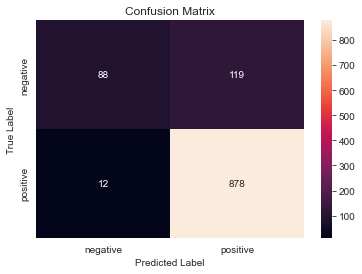

In [22]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train_vect, y_train)
naive_bayes_pred = classifier.predict(X_test_vect)

# Classification Report
print(classification_report(y_test, naive_bayes_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, naive_bayes_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.53      0.67       207
           1       0.90      0.99      0.94       890

    accuracy                           0.90      1097
   macro avg       0.91      0.76      0.81      1097
weighted avg       0.91      0.90      0.89      1097



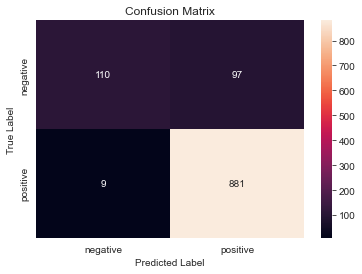

In [23]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=150)
classifier.fit(X_train_vect, y_train)
random_forest_pred = classifier.predict(X_test_vect)

# Classification report
print(classification_report(y_test, random_forest_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, random_forest_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.48      0.64       207
           1       0.89      1.00      0.94       890

    accuracy                           0.90      1097
   macro avg       0.94      0.74      0.79      1097
weighted avg       0.91      0.90      0.89      1097



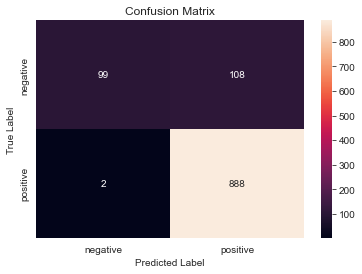

In [24]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train_vect, y_train)
log_reg_pred = classifier.predict(X_test_vect)
# Classification report
print(classification_report(y_test, log_reg_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, log_reg_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [25]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train_vect, y_train)
svm_pred = classifier.predict(X_test_vect)
# Classification report
print(classification_report(y_test, svm_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, svm_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       0.28      0.06      0.10       207
           1       0.82      0.96      0.88       890

    accuracy                           0.79      1097
   macro avg       0.55      0.51      0.49      1097
weighted avg       0.71      0.79      0.74      1097



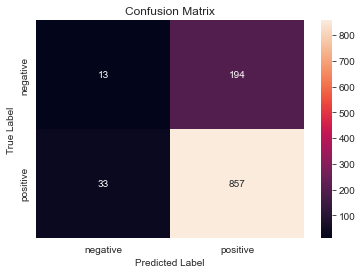

In [26]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(X_train_vect, y_train)
knn_pred = classifier.predict(X_test_vect)

# Classification report
print(classification_report(y_test, knn_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, knn_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.59      0.72       207
           1       0.91      0.99      0.95       890

    accuracy                           0.92      1097
   macro avg       0.93      0.79      0.84      1097
weighted avg       0.92      0.92      0.91      1097



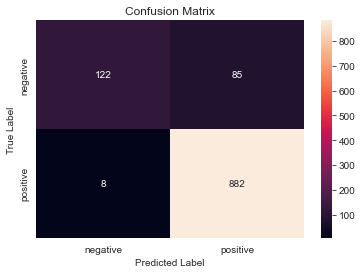

In [27]:
from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier(n_estimators=150, random_state=50)
classifier.fit(X_train_vect, y_train)
extra_trees_pred = classifier.predict(X_test_vect)

# Classification report
print(classification_report(y_test, extra_trees_pred))

# Confusion Matrix
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, extra_trees_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

models = [
          MultinomialNB(),
          LogisticRegression(),
          RandomForestClassifier(n_estimators = 150),
          SVC(kernel = 'linear'),
          KNeighborsClassifier(n_neighbors = 5),
          ExtraTreesClassifier(n_estimators=150, random_state=50)
         ]
names = ["Naive Bayes", "Logistic Regression", "Random Forest", "SVM", "KNN", "Extra Trees"]
for model, name in zip(models, names):
    print(name)
    for score in ["accuracy", "precision", "recall", "f1"]:
        print(f" {score} - {cross_val_score(model, X_train_vect, y_train, scoring=score, cv=10).mean()} ")
    print()

Naive Bayes
 accuracy - 0.8508107352530054 
 precision - 0.8532279902201971 
 recall - 0.974382859804378 
 f1 - 0.9096569733351887 

Logistic Regression
 accuracy - 0.8794240984064858 
 precision - 0.8690413653053527 
 recall - 0.9938053097345133 
 f1 - 0.9271273016458901 

Random Forest
 accuracy - 0.8800997111173237 
 precision - 0.8781080545472049 
 recall - 0.9814314547430522 
 f1 - 0.9255546181213516 

SVM
 accuracy - 0.8910073618488491 


In [28]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 10)
# from sklearn.ensemble import ExtraTreesClassifier
# classifier = ExtraTreesClassifier(n_estimators=150, random_state=50)

classifier.fit(tfidf_train, y_train)
classifier.score(tfidf_test, y_test)

0.9115770282588879

In [29]:
data = ["Bad", "Good", "I love the service, it's really good", "Worst"]
vect = tfidf.transform(data).toarray()

my_pred = classifier.predict(vect)
print(my_pred)

[0 1 1 0]


In [30]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_cv = cv.fit_transform(df['lemmatized_review']) # Fit the Data
y_cv = df['label']

from sklearn.model_selection import train_test_split
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cv, y_cv, test_size=0.3, random_state=42)

In [31]:
#Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

clf.fit(X_train_cv, y_train_cv)
clf.score(X_test_cv, y_test_cv)


0.9179580674567

In [32]:
data = ["Bad", "Worst service, don't go there", "Services are OK", "Good service", "The nurse is so kind"]
vect = cv.transform(data).toarray()

my_prediction = clf.predict(vect)
print(my_prediction)

[0 0 1 1 1]
